# Exploratory Data Analysis
***
Used dask mostly to get the filesize manegeable to take a look at what the data actually is (this is at bottom). <br>
There really isn't much to see here except for nitty gritty EDA work, so I did not clean this up.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import dask.dataframe as dd
import pyspark

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tqdm import tqdm
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [3]:
#I like my graphs humungous, I have old eyes
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['figure.figsize'] = (15,9)

In [3]:
# train = pd.read_csv("train.csv", nrows=100000000,
#                     dtype={'acoustic_data': np.int16})
# train.head(5)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [13]:
with open("train_df","wb") as pickle_out:
    pickle.dump(train, pickle_out)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000000 entries, 0 to 99999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 953.7 MB


In [51]:
train.describe()

,acoustic_data,time_to_failure
count,1.000000e+08,1.000000e+08
mean,4.648496e+00,6.447961e+00
std,1.041905e+01,3.842484e+00
min,-4.621000e+03,6.954822e-04
25%,2.000000e+00,3.120298e+00
50%,5.000000e+00,6.366700e+00
75%,7.000000e+00,9.613998e+00
max,3.914000e+03,1.418060e+01


In [11]:
train.iloc[6000000]

acoustic_data       3.000000
time_to_failure    11.452496
Name: 6000000, dtype: float64

In [54]:
outlier = train[(train['acoustic_data'] > 10) | (train['acoustic_data'] < -10)]

In [55]:
len(outlier)/len(train)

0.07513433

In [56]:
earthquake = train[(train['acoustic_data'] > 100) | (train['acoustic_data'] < -100)]

In [57]:
len(earthquake)

40874

In [58]:
train.iloc[1]

acoustic_data      6.0000
time_to_failure    1.4691
Name: 1, dtype: float64

In [59]:
sample = train.iloc[:10000000]

In [60]:
sample.describe()

,acoustic_data,time_to_failure
count,1.000000e+07,1.000000e+07
mean,4.502072e+00,5.183598e+00
std,1.780707e+01,5.091286e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,6.498971e-01
50%,4.000000e+00,1.298899e+00
75%,7.000000e+00,1.089170e+01
max,3.252000e+03,1.154080e+01


In [17]:
#Helper function to graph acoustic data with time to failure.
def make_dualline(df):
    fig, ax1 = plt.subplots()
    plt.title('Acoustic Data and Time to Failure', fontsize=30)

    color = 'tab:orange'
    ax1.set_xlabel('index', fontsize=25)
    ax1.set_ylabel('Time to Failure', color=color, fontsize=20)
    ax1.plot(df['time_to_failure'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Acoustic Data', color=color, fontsize=20)  # we already handled the x-label with ax1
    ax2.plot(df['acoustic_data'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

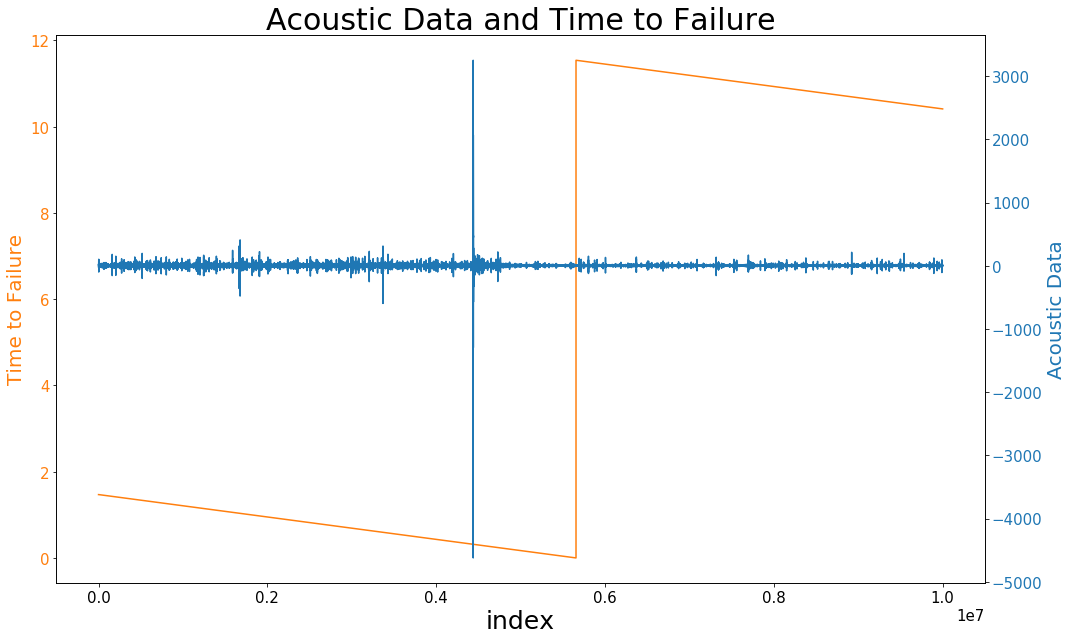

In [108]:
make_dualline(sample)

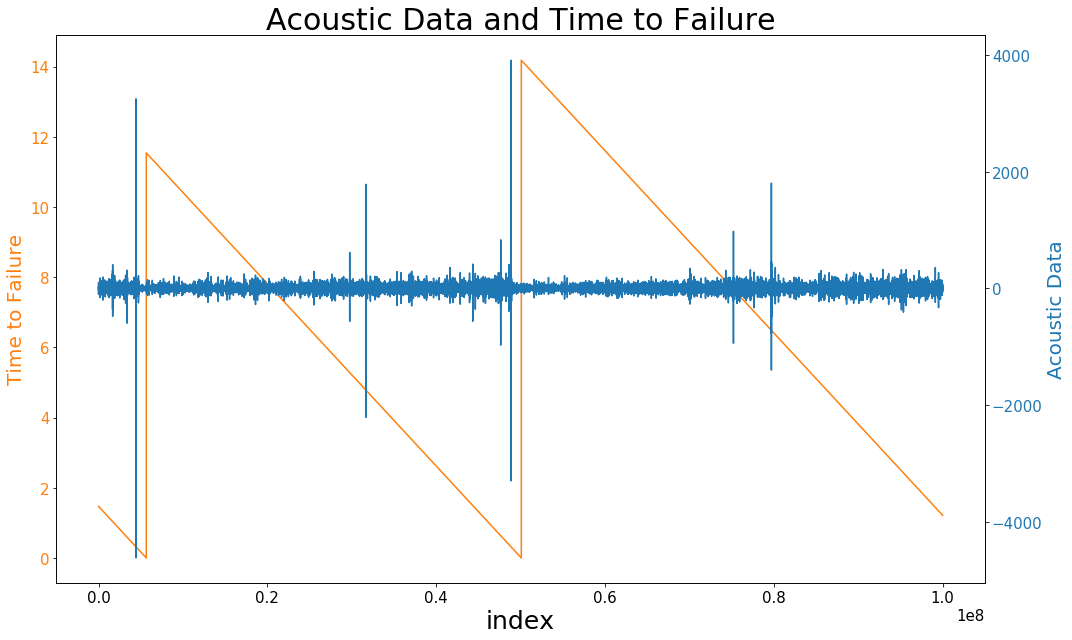

In [107]:
#100 million
make_dualline(train)

Checking for where the first quake occurs, but I discovered that the actual failure occurs several seconds later. This is true for apparently all of the failures.

In [62]:
quake = sample[(sample['acoustic_data'] > 1000) | (sample['acoustic_data'] < -1000)]

In [63]:
quake.describe()

,acoustic_data,time_to_failure
count,695.000000,695.000000
mean,-3.303597,0.316771
std,1782.189598,0.000158
min,-4621.000000,0.315800
25%,-1488.500000,0.316796
50%,-1003.000000,0.316797
75%,1512.500000,0.316797
max,3252.000000,0.316798


### Graphing time to failure vs seismic data for presentation

In [100]:
!cat train.csv | wc -l

 629145481


In [5]:
trainlength = 629145481

In [6]:
n_rows = trainlength
skip = np.arange(n_rows)
skip = np.delete(skip, np.arange(0, n_rows, 100))
onepercent = pd.read_csv('../input/train.csv', skiprows = skip)

KeyboardInterrupt: 

In [ ]:
len(onepercent)

In [19]:
with open ("../pickle/onepercent","wb") as pickle_out:
    pickle.dump(onepercent, pickle_out)

In [7]:
with open("../pickle/onepercent","rb") as pickle_in:
    onepercent = pickle.load(pickle_in)

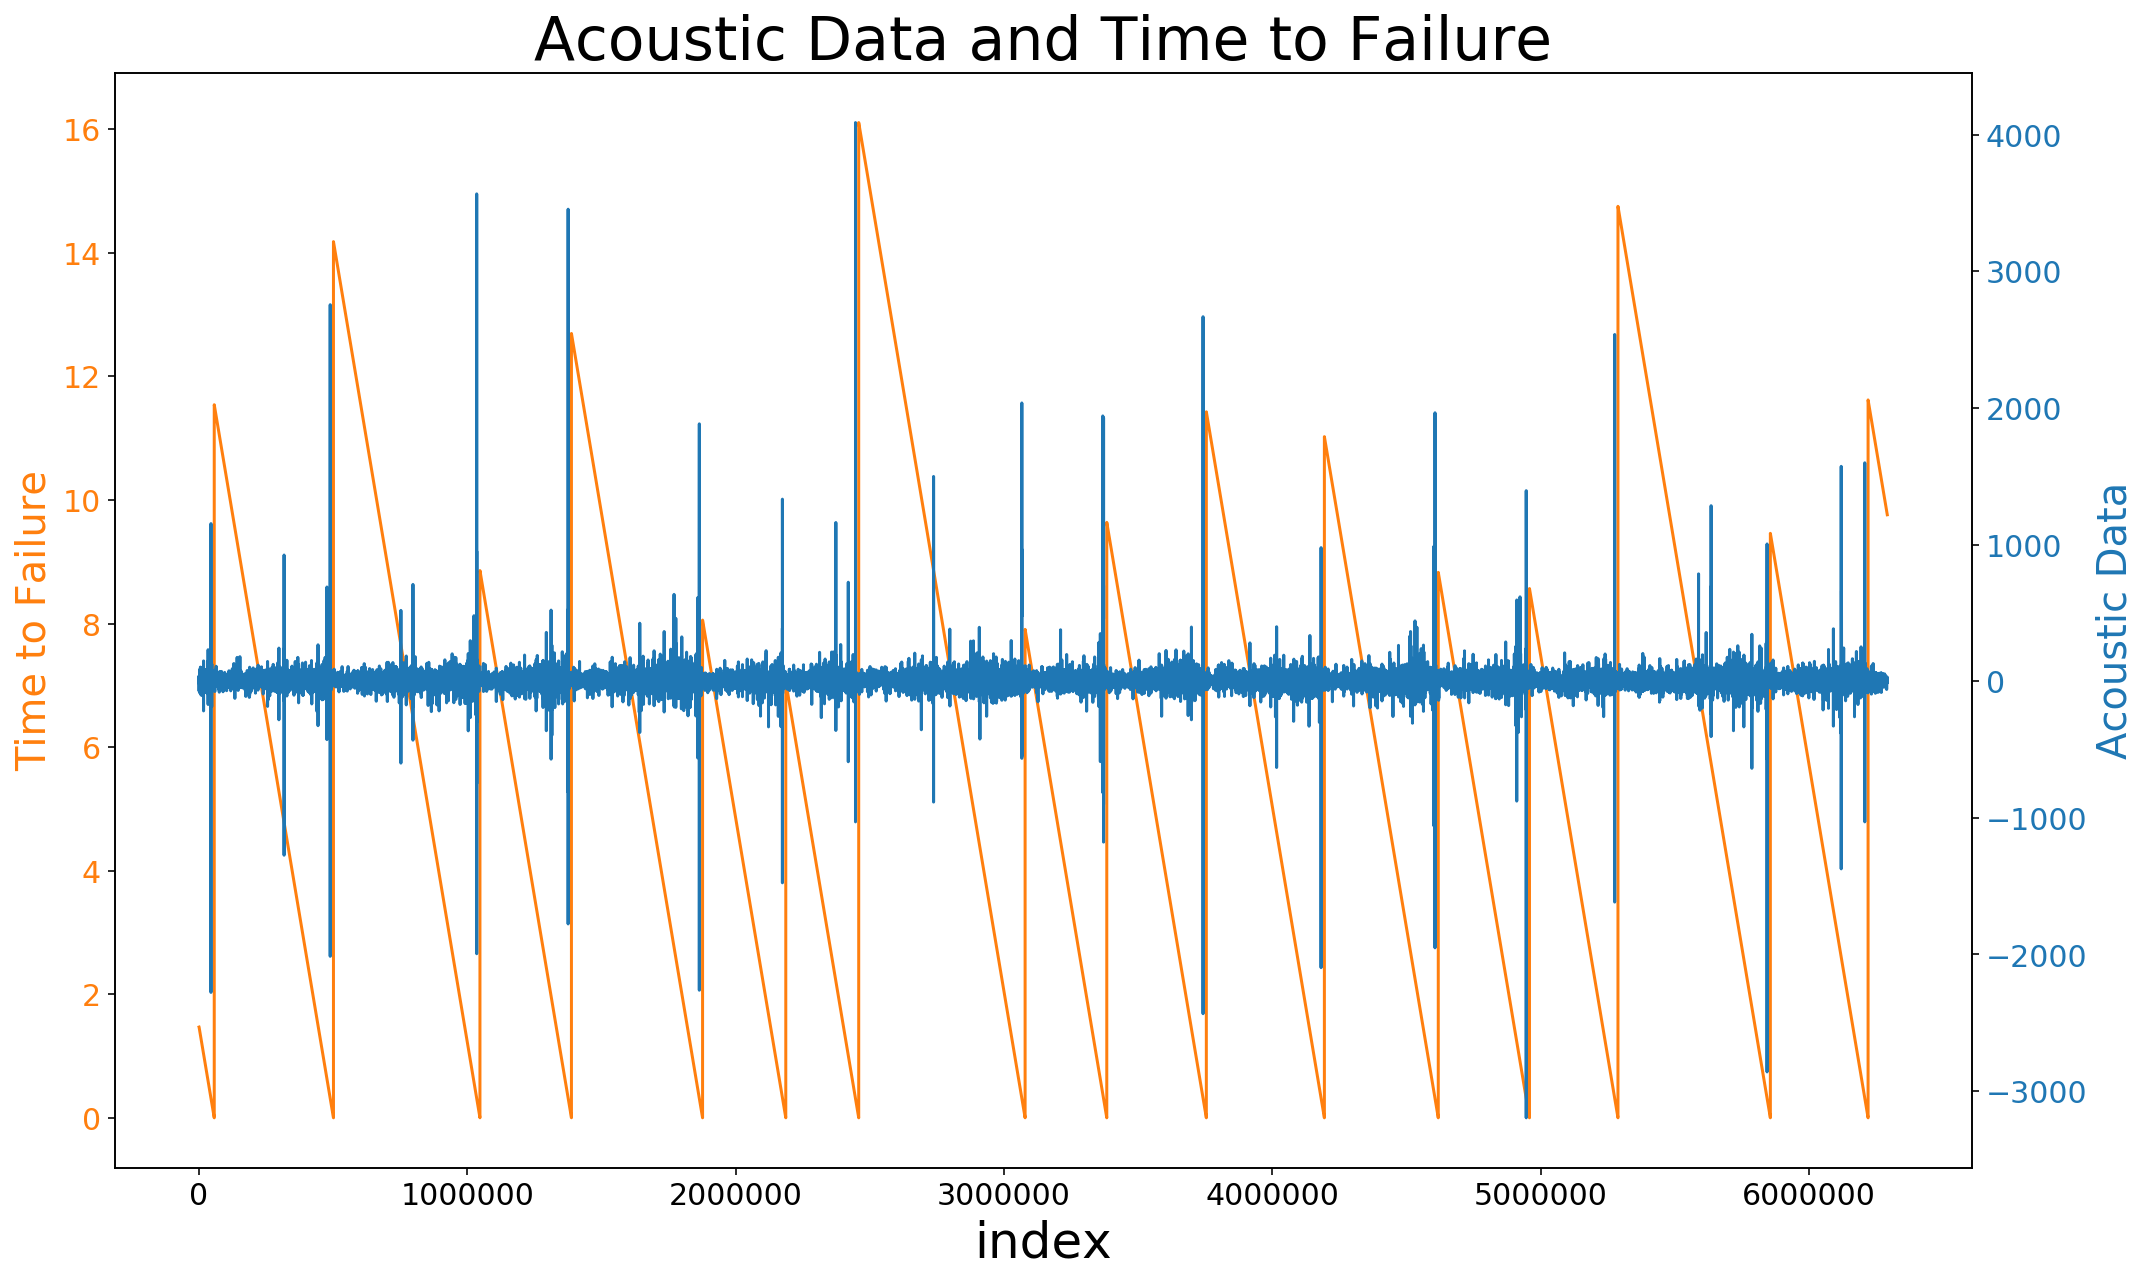

In [10]:
make_dualline(onepercent)

Text(0.5, 0, 'index')

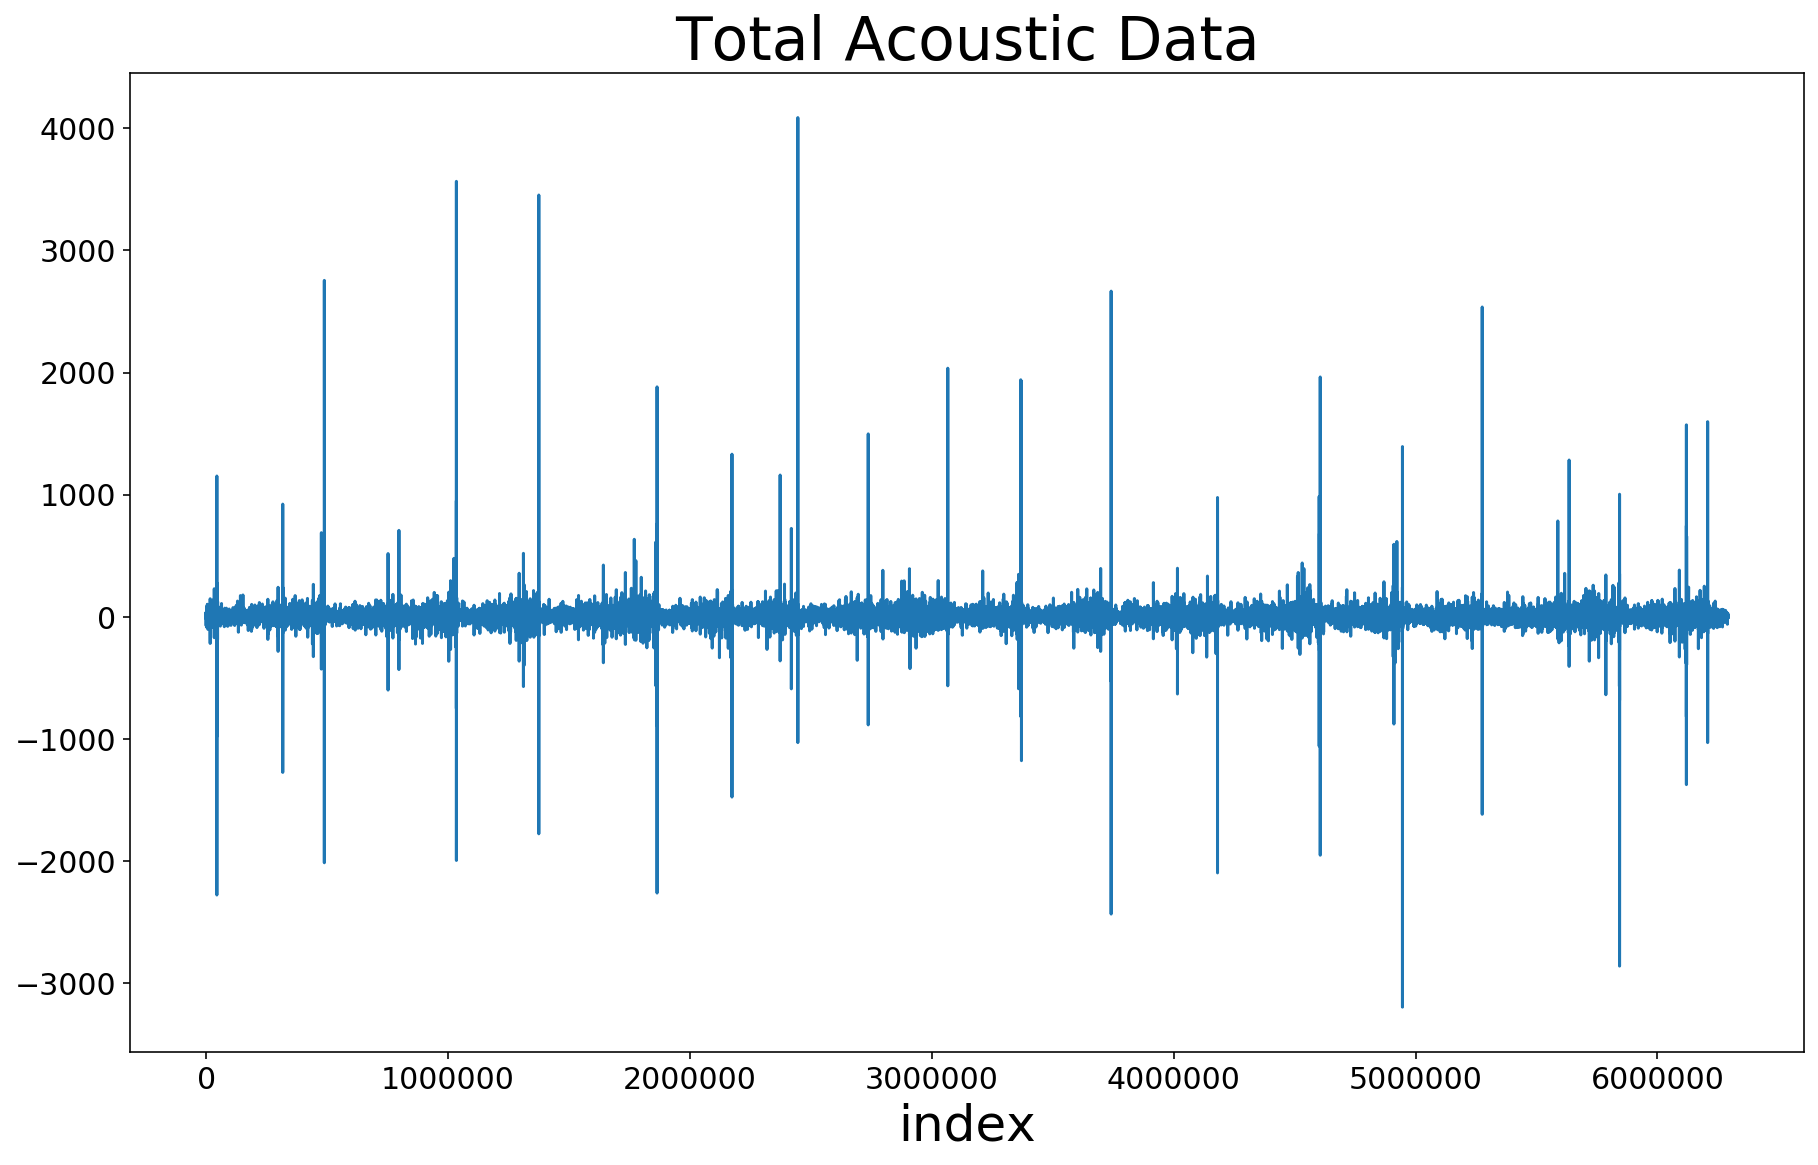

In [16]:
ax = plt.plot(onepercent['acoustic_data'])
plt.title('Total Acoustic Data', fontsize=30)
plt.xlabel('index', fontsize=25)

In [15]:
onepercent = onepercent.reset_index()
onepercent = onepercent.rename(columns={'index':'time'})
onepercent.describe()

TSFRESH ATTEMPT

In [4]:
#tsfresh requires the data to be in a SUPER SPECIFIC format, so here is a helper function to do just that
def tsfreshifyX(df,n):
    temp = df.copy().reset_index()
    temp = temp.rename(columns={'index':'time'})
    X = temp.copy().drop(columns = ['time_to_failure'])
    X['id'] = n
    return X

In [53]:
thousandth = onepercent.copy()[::10]
thousandth['time'] = thousandth['time']/10
thousandth['time'] = thousandth['time'].astype(int)

In [9]:
thousandth.head()

,time,acoustic_data,time_to_failure
0,0,9,1.469100
10,1,17,1.469099
20,2,6,1.469098
30,3,18,1.469097
40,4,-3,1.468100


In [10]:
X_thou = thousandth.copy().drop(columns = ['time_to_failure'])
X_thou['id'] = 1
y_thou = thousandth.copy().drop(columns = ['time','acoustic_data'])

In [29]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

In [13]:
extracted_features = extract_features(X_thou, column_id="id", column_sort="time", n_jobs=4,default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


In [165]:
extracted_features2 = extracted_features2.copy().reindex([2])

In [71]:
with open ("../pickle/thousandth","wb") as pickle_out:
    pickle.dump(thousandth, pickle_out)

In [3]:
with open("../pickle/thousandth","rb") as pickle_in:
    thousandth = pickle.load(pickle_in)

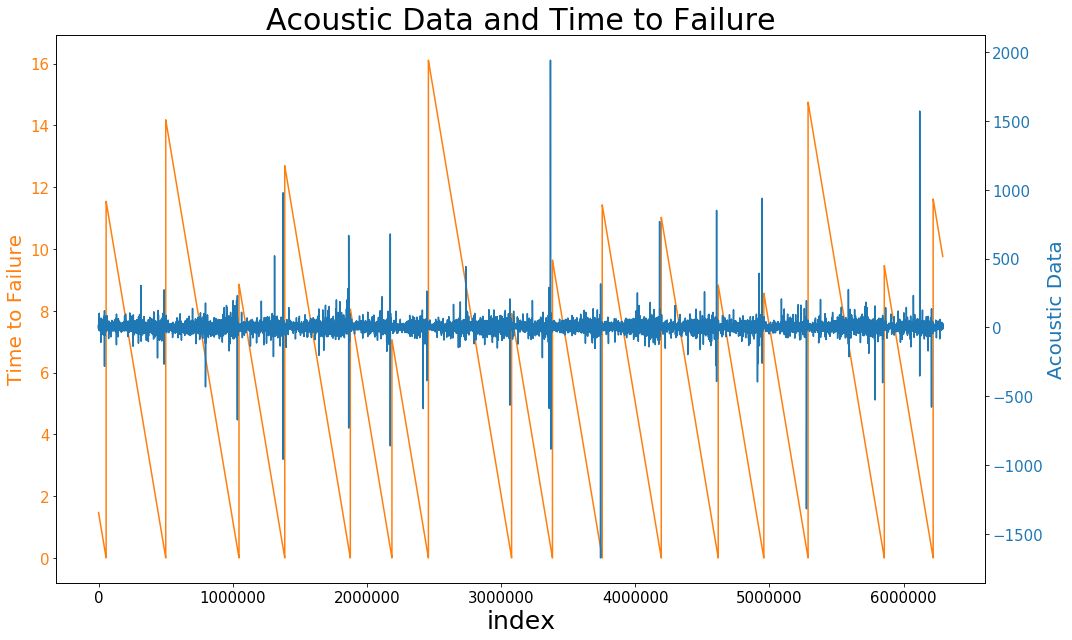

In [6]:
make_dualline(thousandth)

In [7]:
set1 = pd.read_csv("../input/train.csv", nrows=150000,
                    dtype={'acoustic_data': np.int16})
set1.head(5)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [115]:
X1, y1 = tsfreshify(set1)

In [116]:
y1.head()

,time_to_failure
0,1.4690998743
10,1.4690987743
20,1.4690976743
30,1.4690965743
40,1.4680999799


In [30]:
#"Efficient" set of features still took 3 minutes per sample...
extracted_features1 = extract_features(X1, column_id="id", column_sort="time", n_jobs=4,default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 1/1 [03:40<00:00, 220.63s/it]


In [182]:
extracted_features1

variable,acoustic_data__abs_energy,acoustic_data__absolute_sum_of_changes,"acoustic_data__agg_autocorrelation__f_agg_""mean""__maxlag_40","acoustic_data__agg_autocorrelation__f_agg_""median""__maxlag_40","acoustic_data__agg_autocorrelation__f_agg_""var""__maxlag_40","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,acoustic_data__symmetry_looking__r_0.9,acoustic_data__symmetry_looking__r_0.9500000000000001,acoustic_data__time_reversal_asymmetry_statistic__lag_1,acoustic_data__time_reversal_asymmetry_statistic__lag_2,acoustic_data__time_reversal_asymmetry_statistic__lag_3,acoustic_data__value_count__value_-1,acoustic_data__value_count__value_0,acoustic_data__value_count__value_1,acoustic_data__variance,acoustic_data__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1,10247.0,391980.0,-0.01961691716279,-0.029210568892279,0.077172793318692,11.472805164100171,-0.160479930802853,-0.00017058983898,0.000008567421122,15.549423081195156,...,1.0,1.0,0.259256790090535,3.830395477212726,-4.118364734589384,3622.0,5741.0,8406.0,26.021110280488884,1.0


In [183]:
extracted_features2

variable,acoustic_data__abs_energy,acoustic_data__absolute_sum_of_changes,"acoustic_data__agg_autocorrelation__f_agg_""mean""__maxlag_40","acoustic_data__agg_autocorrelation__f_agg_""median""__maxlag_40","acoustic_data__agg_autocorrelation__f_agg_""var""__maxlag_40","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","acoustic_data__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,acoustic_data__symmetry_looking__r_0.9,acoustic_data__symmetry_looking__r_0.9500000000000001,acoustic_data__time_reversal_asymmetry_statistic__lag_1,acoustic_data__time_reversal_asymmetry_statistic__lag_2,acoustic_data__time_reversal_asymmetry_statistic__lag_3,acoustic_data__value_count__value_-1,acoustic_data__value_count__value_0,acoustic_data__value_count__value_1,acoustic_data__variance,acoustic_data__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And if you thought tsfresh was finicky about formating for feature extraction, wait until you try feature selection....ugh...

In [42]:
pd.set_option("display.precision", 15)

In [50]:
set2 = pd.read_csv("../input/train.csv", skiprows = range(1,150001), nrows=150000,
                    dtype={'acoustic_data': np.int16})
ys = pd.DataFrame([[1.4307971847999998],[1.391498892]],columns = ['time_to_failure'], index=[1,2])
X2, y2 = tsfreshify(set2,2)

In [188]:
extracted_features2 = extract_features(X2, column_id="id", column_sort="time", n_jobs=4,default_fc_parameters=EfficientFCParameters())


Feature Extraction: 100%|██████████| 1/1 [03:33<00:00, 213.00s/it]

In [6]:
rows = 150000
sets = []
for n in range(4194):
    sets.append(pd.read_csv("../input/train.csv", skiprows = range(1,rows*n+1), nrows=rows,
                    dtype={'acoustic_data': np.int16}))

KeyboardInterrupt: 

In [89]:
y1 = pd.read_csv("../input/train.csv",skiprows = range(1,150000+1), nrows=1, dtype={'acoustic_data': np.int16})

In [92]:
ylist = []
for n in range(10):
    ylist.append(pd.read_csv("../input/train.csv",skiprows = range(1,150000*n+1), nrows=1,
                    dtype={'acoustic_data': np.int16}))

In [94]:
ylist[0]

,acoustic_data,time_to_failure
0,12,1.4690999832


In [98]:
ys = []
for df in ylist:
    ys.append(df['time_to_failure'][0])

In [100]:
ys

[1.4690999832,
 1.4307971847999998,
 1.391498892,
 1.3531960936,
 1.3137978008,
 1.274399508,
 1.2360967096,
 1.1967984168,
 1.1584956184,
 1.1190973256]

In [61]:
sets[4].tail()

,acoustic_data,time_to_failure
149995,7,1.1967984223
149996,4,1.1967984212
149997,5,1.1967984201
149998,8,1.1967984190
149999,5,1.1967984179


In [60]:
sets[5].head()

,acoustic_data,time_to_failure
0,3,1.1967984168
1,2,1.1967984157
2,6,1.1967984146
3,6,1.1967984135
4,6,1.1967984124


In [64]:
ef_list = []
for n in range(2,10):
    X = tsfreshifyX(sets[n])
    ef_list.append(extract_features(X, column_id="id", column_sort="time", n_jobs=4,default_fc_parameters=EfficientFCParameters()))


Feature Extraction: 100%|██████████| 1/1 [03:27<00:00, 207.06s/it]

In [103]:
ef_list = [extracted_features1] + [extracted_features2] + ef_list
extracted = pd.concat([extracted_features1,extracted_features2])

### Trying to select features I want (I would have to move to bigger CPU for this later)

In [195]:
features_filtered = select_features(extracted_features1, ys['time_to_failure'][0])

## Dask Analysis

In [4]:
traindd = dd.read_csv('train.csv')
traindd.shape[0].compute()

In [12]:
pd.options.display.precision = 10
pd.options.display.max_rows = 10

In [13]:
traindd.head(3)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810


In [14]:
traindd.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 2 entries, acoustic_data to time_to_failure
dtypes: float64(1), int64(1)

In [36]:
traindd.mean()

Dask Series Structure:
npartitions=1
acoustic_data      float64
time_to_failure        ...
dtype: float64
Dask Name: dataframe-mean, 1352 tasks

In [38]:
traindd.describe().compute()

,acoustic_data,time_to_failure,time_diff
count,6.2914548000e+08,6.2914548000e+08,6.2914547900e+08
mean,4.5194675737e+00,5.6782917130e+00,1.3177708190e-08
std,1.0735707250e+01,3.6726965194e+00,1.7600098186e-03
min,-5.5150000000e+03,9.5503963166e-05,-1.0954970000e-03
25%,3.0000000000e+00,3.4813956145e+00,-1.1000000910e-09
50%,5.0000000000e+00,7.0691985086e+00,-1.1000000910e-09
75%,8.0000000000e+00,1.5840396413e+01,-9.9999830638e-10
max,5.4440000000e+03,1.6107400000e+01,1.6106904507e+01


In [16]:
traindd['time_diff'] = traindd['time_to_failure'].diff()
traindd['original_index'] = traindd.index

In [103]:
traindd.head()

,acoustic_data,time_to_failure,time_diff,original_index
0,12,1.4690999832,NaN,0
1,6,1.4690999821,-0.0000000011,1
2,8,1.4690999810,-0.0000000011,2
3,5,1.4690999799,-0.0000000011,3
4,8,1.4690999788,-0.0000000011,4


In [104]:
bob = traindd['time_diff'] > 0

In [46]:
bob.describe().compute()

unique            2
count     629145480
top           False
freq      629145464
Name: time_diff, dtype: object

In [105]:
temp = traindd[bob]

In [99]:
temp.head()

//anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:5721: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,acoustic_data,time_to_failure,time_diff


In [106]:
pd.set_option('display.max_rows', 30)
temp.compute()

,acoustic_data,time_to_failure,time_diff,original_index
1588474,4,11.5407999870,11.5400045072,1588474
3702121,1,14.1805999900,14.1799045078,3702121
3469158,4,8.8566999914,8.8559045063,3469158
3879913,-4,12.6939999940,12.6929045071,3879913
2270332,2,8.0554999956,8.0549045061,2270332
3720000,4,7.0589999970,7.0579045059,3720000
1414101,2,16.1074000000,16.1069045075,1414101
208349,2,7.9056000019,7.9049045061,208349
1119617,3,9.6371000039,9.6369045065,1119617
368492,0,11.4264000060,11.4259045066,368492


In [144]:
traindd['original_index'] = 1
traindd['original_index'] = traindd.original_index.cumsum()
traindd = traindd.set_index('original_index', sorted=True)

In [153]:
traindd.reset_index()['original_index'].tail()

1304332    629145476
1304333    629145477
1304334    629145478
1304335    629145479
1304336    629145480
Name: original_index, dtype: int64

In [154]:
resetdd = traindd.reset_index()
failure_mask = resetdd['time_diff'] > 0
failures = resetdd[failure_mask].compute()

In [171]:
failures

,original_index,acoustic_data,time_to_failure,time_diff
1588474,5656575,4,12,12
3702121,50085879,1,14,14
3469158,104677357,4,8.9,8.9
3879913,138772454,-4,13,13
2270332,187641821,2,8.1,8.1
3720000,218652631,4,7.1,7.1
1414101,245829586,2,16,16
208349,307838918,2,7.9,7.9
1119617,338276288,3,9.6,9.6
368492,375377849,0,11,11


In [163]:
failure_index = failures['original_index'].tolist()
failure_time = failures['time_to_failure'].tolist()

In [165]:
# with open("failure_index","wb") as pickle_out:
#     pickle.dump(failure_index, pickle_out)
# with open("failure_time","wb") as pickle_out:
#     pickle.dump(failure_index, pickle_out)

In [183]:
df1 = pd.read_csv('train.csv',skiprows = range(1,failure_index[0]), 
                  nrows = (failure_index[1]-failure_index[0]),dtype={'acoustic_data': np.int16})

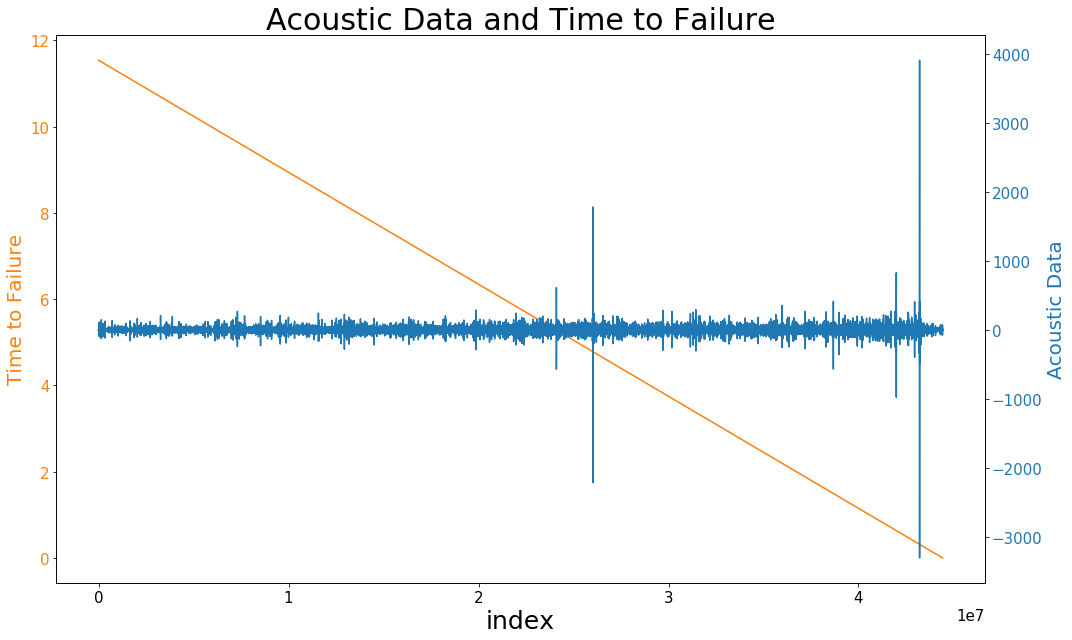

In [186]:
make_dualline(df1)

In [ ]:
df1 = pd.read_csv('train.csv',skiprows = range(1,failure_index[0]), 
                  nrows = (failure_index[1]-failure_index[0]),dtype={'acoustic_data': np.int16})

In [16]:
# with open("df1","wb") as pickle_out:
#     pickle.dump(df1, pickle_out)

NameError: name 'df1' is not defined

In [214]:
# with open("pickle/failure_index","rb") as pickle_in:
#     failure_index = pickle.load(pickle_in)

In [223]:
dflist = []
for i in range(8,15):
    dflist.append(pd.read_csv('train.csv',skiprows = range(1,failure_index[i]), nrows = (failure_index[i+1]-failure_index[i]),dtype={'acoustic_data': np.int16}))

In [244]:
# with open("pickle/df15","wb") as pickle_out:
#     pickle.dump(dflist[10], pickle_out)

In [233]:
len(dflist)

11

In [225]:
df9.describe()

,acoustic_data,time_to_failure
count,3.1e+07,3.1e+07
mean,4.5,4
std,11,2.3
min,-2.5e+03,0.0011
25%,2,2
50%,4,4
75%,7,6
max,3.7e+03,8.1


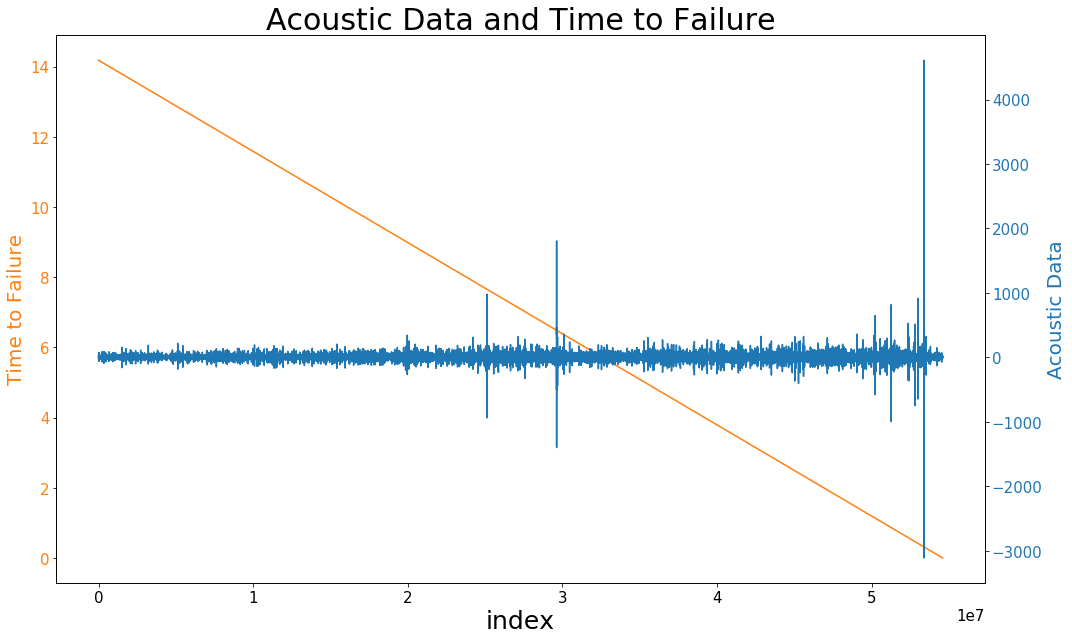

In [206]:
make_dualline(df1)

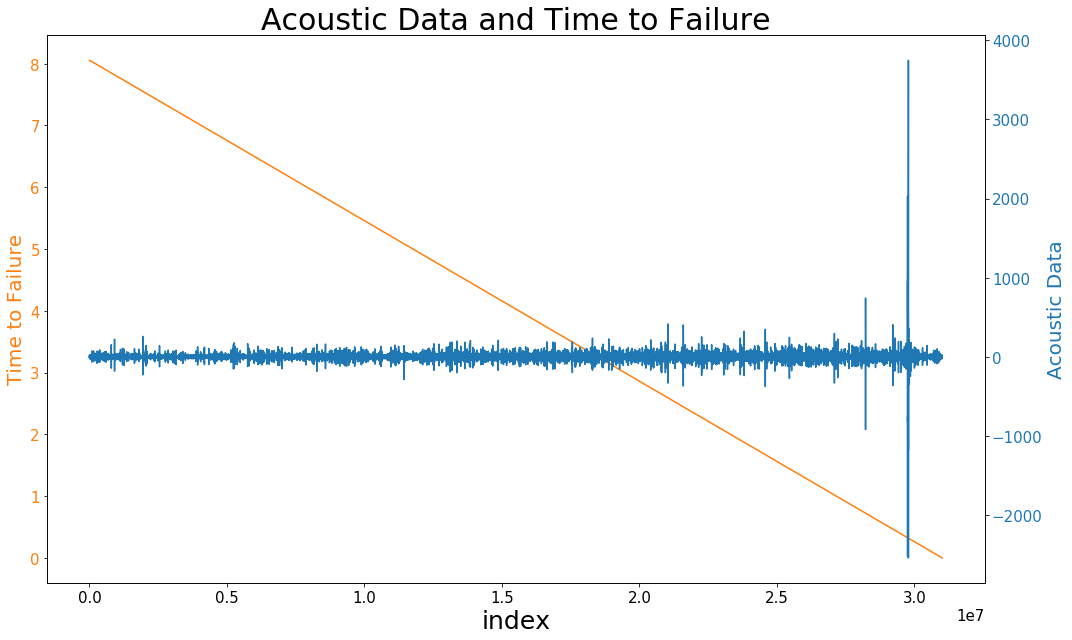

In [247]:
make_dualline(dflist[0])